In [3]:
import tensorflow as tf
import tensorflow_datasets as tdfs
import tensorflow_hub as hub
import numpy as np
import matplotlib.pylab as plt


In [4]:
import keras.backend as k

In [5]:
data,info = tdfs.load('beans',as_supervised= True, split = ['train','test','validation'],with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete5NMXD3/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete5NMXD3/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete5NMXD3/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

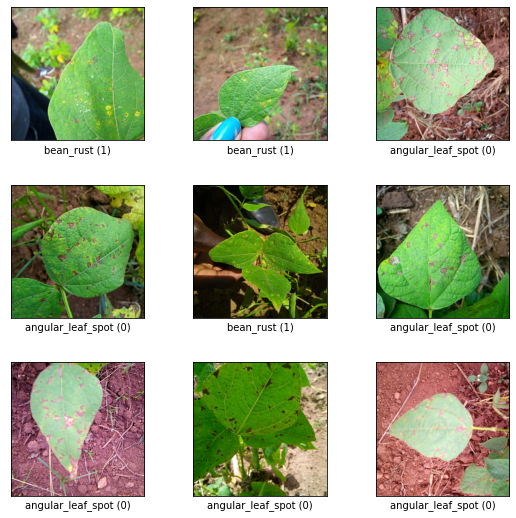

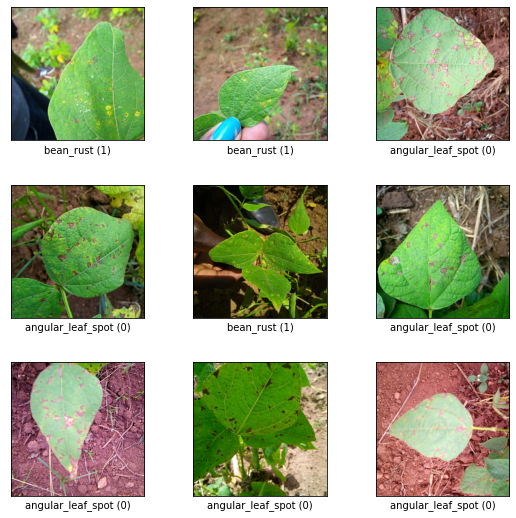

In [7]:
train,info1 = tdfs.load('beans',split = 'train',with_info=True)
tdfs.show_examples(info1,train)

In [8]:
def normalise(img,label):
  image = tf.cast(img,tf.float32)
  image /= 255.0
  return tf.image.resize(image,[224,224]),tf.one_hot(label,3)

In [9]:
def getdata(batch_size = 32):
  train_ds = data[0].map(normalise).shuffle(1000).batch(batch_size)
  test = data[1].map(normalise).batch(batch_size)
  validation = data[2].map(normalise).batch(batch_size)
  return train_ds,test,validation

In [10]:
train_ds, test_ds,val_ds = getdata()

In [11]:
train_ds.cache
val_ds.cache

<bound method DatasetV2.cache of <DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>>

In [12]:
pre_train = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [13]:
pre_layer = hub.KerasLayer(pre_train,input_shape=(224,224,3))

In [14]:
pre_layer.trainable = False

In [15]:
model = tf.keras.Sequential(
    [pre_layer,
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3,activation='softmax')]                        )

In [16]:
model.compile(optimizer= tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics = ['accuracy'])

In [17]:
model.fit(train_ds,epochs=12,validation_data= val_ds)

Epoch 1/12
33/33 [==============================] - 5s 139ms/step - loss: 0.9756 - accuracy: 0.5687 - val_loss: 0.8087 - val_accuracy: 0.7820
Epoch 2/12
33/33 [==============================] - 3s 94ms/step - loss: 0.8062 - accuracy: 0.7544 - val_loss: 0.7401 - val_accuracy: 0.8421
Epoch 3/12
33/33 [==============================] - 3s 94ms/step - loss: 0.7797 - accuracy: 0.7872 - val_loss: 0.7142 - val_accuracy: 0.8496
Epoch 4/12
33/33 [==============================] - 3s 93ms/step - loss: 0.7453 - accuracy: 0.8104 - val_loss: 0.7019 - val_accuracy: 0.8496
Epoch 5/12
33/33 [==============================] - 3s 93ms/step - loss: 0.7186 - accuracy: 0.8424 - val_loss: 0.7104 - val_accuracy: 0.8496
Epoch 6/12
33/33 [==============================] - 3s 93ms/step - loss: 0.7041 - accuracy: 0.8482 - val_loss: 0.6833 - val_accuracy: 0.8571
Epoch 7/12
33/33 [==============================] - 3s 93ms/step - loss: 0.7010 - accuracy: 0.8617 - val_loss: 0.6782 - val_accuracy: 0.8797
Epoch 8/12
3

In [18]:
result = model.evaluate(test_ds)

4/4 [==============================] - 0s 102ms/step - loss: 0.6630 - accuracy: 0.8750


In [20]:
for x,y in data[1].map(normalise).batch(200):
  y_ = np.argmax(y,axis = 1)
  yhat = np.argmax(model.predict(x),axis = 1)
  print(tf.math.confusion_matrix(labels = y_,predictions = yhat,num_classes = 3))

tf.Tensor(
[[40  3  0]
 [ 7 34  2]
 [ 0  4 38]], shape=(3, 3), dtype=int32)
